### Base settings

In [22]:
%load_ext autoreload
%autoreload 2

import time
from tqdm import tqdm
from pprint import pprint
from pathlib import Path
from collections import OrderedDict

import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10-ood_8.yaml'
# config_path = Path('configs') / 'custom_vit_tiny-scratch-cifar10-ood_8.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [10]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name
checkpoint_path = log_root / 'checkpoints'

In [11]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

if config.model.pretrained:
    model = torch.hub.load(
        repo_or_dir=config.model.repo,
        model=config.model.pretrained_model,
        pretrained=False,
    )
else:
    model = ViT(
        image_size=config.model.img_size,
        patch_size=config.model.patch_size,
        num_classes=len(config.dataset.in_distribution_class_indices),
        dim=config.model.dim_head,
        depth=config.model.depth,
        heads=config.model.n_heads,
        mlp_dim=config.model.dim_mlp,
        dropout=config.model.dropout,
        emb_dropout=config.model.emb_dropout,
        visualize=True,
    )

model = model.to(device=device)
print(model)

checkpoint = torch.load(checkpoint_path / f'{summary}_best.pt')

state_dict = checkpoint['model_state_dict']
trimmed_keys = []
for key in state_dict.keys():
    # remove prefix 'module.' for each key (in case of DataParallel)
    trimmed_keys.append(key[7:])
trimmed_state_dict = OrderedDict(list(zip(trimmed_keys, state_dict.values())))

model.load_state_dict(trimmed_state_dict)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), ep

<All keys matched successfully>

In [23]:
from ood_with_vit.datasets import OOD_CIFAR10

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size
in_distribution_class_indices = config.dataset.in_distribution_class_indices

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

dataset = OOD_CIFAR10(
    root=dataset_root, 
    in_distribution_class_indices=in_distribution_class_indices, 
    train=False, 
    download=False, 
    transform=transform_test
)
testloader = DataLoader(
    dataset=dataset,
    batch_size=config.eval.batch_size,
    shuffle=False,
    num_workers=8,
)

class_indices = list(range(10))
idx_to_class = dict((v, k) for k, v in dataset.class_to_idx.items())
ood_class_indices = [i for i in class_indices if i not in in_distribution_class_indices]
in_class_indices = [i for i in class_indices if i in in_distribution_class_indices]
print(dataset.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


### Utility functions

In [14]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

### Visualize attention maps

In [32]:
from ood_with_vit.visualizer import ViTAttentionRollout
from ood_with_vit.utils import (
    compute_attention_maps,
    compute_logits,
)

def visualize_results(original_img, attn_weights, seed=None):
    if seed is not None:
        set_seed(seed)
    visualizer = ViTAttentionRollout()
    mask = visualizer.rollout(attn_weights)

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)

    plt.subplot(1, 3, 2)
    visualized_img = visualizer.get_visualized_masks(original_img, mask)
    visualized_img = visualized_img[:, :, ::-1]
    plt.imshow(visualized_img)

    plt.subplot(1, 3, 3)
    plt.imshow(mask)
    cax = fig.add_axes([
        ax.get_position().x1 + 0.01,
        ax.get_position().y0 + ax.get_position().height * 0.2, 
        0.02,
        ax.get_position().height * 0.6
    ])
    plt.colorbar(cax=cax)

    plt.show()
    
    return mask

#### Test in-distribution samples

In [24]:
# calculate in-distribution data statistics
model.eval()

accuracy = {}
with torch.no_grad():
    for in_class_idx in in_class_indices:
        class_name = idx_to_class[in_class_idx]
        total, count = len(dataset.img_dict[in_class_idx]), 0
        for i in tqdm(range(len(dataset.img_dict[in_class_idx]))):
            test_img = dataset.get_transformed_image(in_class_idx, i)
            test_img = test_img.to(device=device)
            logits = compute_logits(config, model, test_img.unsqueeze(0))
            # logit, _ = model(test_img.unsqueeze(0))
            _, max_class = logits.max(1)
            if max_class == in_class_idx:
                count += 1
        accuracy[class_name] = count / total

mean_acc = 0
for acc in accuracy.values():
    mean_acc += acc
mean_acc /= len(accuracy.values())

pprint(accuracy)
print(f'mean acc: {mean_acc:.4f}')

100%|██████████| 1000/1000 [00:09<00:00, 110.13it/s]

{'airplane': 0.989,
 'automobile': 0.984,
 'bird': 0.964,
 'cat': 0.946,
 'deer': 0.986,
 'dog': 0.931,
 'frog': 0.985,
 'horse': 0.976,
 'truck': 0.0}
mean acc: 0.8623


max logit: 15.367719650268555
max class: cat
logit: [[-0.23198658  1.2449049   3.2664108  15.36772     3.474316    4.392087
   3.4641972   0.31512523  0.49453136 -2.736603   -2.9350672  -3.4428053
  -3.0794573  -1.5243881  -4.1875763  -3.5285697  -3.5295694  -3.1926653
  -3.422053   -2.8917842  -3.1045923  -4.068392   -4.039633   -3.0784245
  -3.5024412  -3.9990919  -2.4813251  -2.5856013  -2.7110465   0.07600039
  -3.8666315  -2.1599143  -3.8476071  -1.8105136  -3.3503458  -4.4913464
  -4.6275373  -3.0036883  -1.7905542  -4.6057544  -2.9705415  -3.4040227
  -4.926566   -3.548983   -3.2891366  -3.6502962  -2.800563   -3.274946
  -3.5041614  -3.7872221  -3.075051   -1.9116606  -2.8861156  -4.082222
  -3.6630101  -3.2959106  -4.064479   -3.5552018  -4.1173425  -2.8507318
  -3.501392   -3.4176812  -3.3670087  -3.5061085  -2.5887606  -2.11945
  -3.5343583  -3.6584463  -3.7032628  -3.9673212  -3.128468   -1.9792674
  -3.786971   -2.7200892  -3.2132688  -2.7329113  -3.0539267  -3.158133
  -2

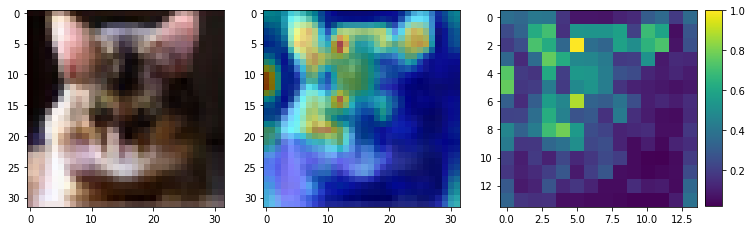

In [28]:
# visualize in-distribution class attention maps.
id_class_name = 'cat' 
id_class_idx, img_idx = dataset.class_to_idx[id_class_name], 50
original_img = dataset.img_dict[id_class_idx][img_idx]

test_img = dataset.get_transformed_image(id_class_idx, img_idx)
test_img = test_img.to(device=device)
attention_maps = compute_attention_maps(config, model, test_img.unsqueeze(0))
logits = compute_logits(config, model, test_img.unsqueeze(0))
# logit, attn_weights = model(test_img.unsqueeze(0))
max_logit, max_class = logits.max(1)
print('max logit:', max_logit.item())
print('max class:', idx_to_class[max_class.item()])
print('logit:', logits.detach().cpu().numpy())
print('attn weights:', len(attention_maps), attention_maps[0].shape)


# _attn_weights = []
# for weight in attn_weights:
#     _attn_weights.append(weight.detach().cpu())
# attn_weights = _attn_weights

visualize_results(original_img, attention_maps, 333)


#### Test out-of-distribution samples

In [12]:
# calculate out-of-distribution data statistics
ood_class_name = 'truck'
ood_class_idx = dataset.class_to_idx[ood_class_name]
counts = {idx_to_class[idx]: 0 for idx in in_class_indices}
for i in range(len(dataset.img_dict[ood_class_idx])):
    test_img = dataset.get_transformed_image(ood_class_idx, i)
    test_img = test_img.to(device=device)
    logit, _ = model(test_img.unsqueeze(0))
    _, max_class = logit.max(1)
    max_class = idx_to_class[max_class.item()]
    counts[max_class] += 1
    
for class_name, count in counts.items():
    ratio = count / len(dataset.img_dict[ood_class_idx])
    counts[class_name] = (count, ratio)
pprint(counts)

{'airplane': (133, 0.133),
 'automobile': (617, 0.617),
 'bird': (16, 0.016),
 'cat': (37, 0.037),
 'deer': (10, 0.01),
 'dog': (15, 0.015),
 'frog': (19, 0.019),
 'horse': (48, 0.048),
 'ship': (105, 0.105)}


max logit: 15.653950691223145
max class: ship
logit: [[ 2.2626400e+00  9.4261909e-01 -9.5042959e-02  2.3049276e+00
   1.3789417e+00  9.3212825e-01 -4.3836311e-02  7.3250556e+00
   1.5653951e+01 -2.4898696e+00 -2.1329532e+00 -2.8429253e+00
  -2.9086559e+00 -2.6708555e+00 -3.5413857e+00 -2.2019897e+00
  -2.6633942e+00 -2.4038222e+00 -2.6809747e+00 -2.8465846e+00
  -2.4053531e+00 -2.1084235e+00 -3.1343210e+00 -2.8514202e+00
  -3.9596813e+00 -3.1787913e+00 -3.7262080e+00 -2.4871931e+00
  -3.4826016e+00 -1.1416152e+00 -3.7403588e+00 -2.5232894e+00
  -3.1838737e+00 -2.7663054e+00 -3.3464026e+00 -2.9678726e+00
  -3.1186602e+00 -1.4184891e+00 -3.7383988e+00 -3.2832627e+00
  -2.9482379e+00 -3.6902280e+00 -2.4910645e+00 -6.2665534e-01
  -2.9947820e+00 -3.3484459e+00 -2.3281186e+00 -4.1399698e+00
  -2.6813102e+00 -2.5640714e+00 -2.4674182e+00 -1.1272742e+00
  -3.3288527e+00 -2.8946507e+00 -3.3794701e+00 -2.3669407e+00
  -3.2058403e+00 -3.8350182e+00 -3.9392595e+00 -1.8660746e+00
  -2.6226227e+00 

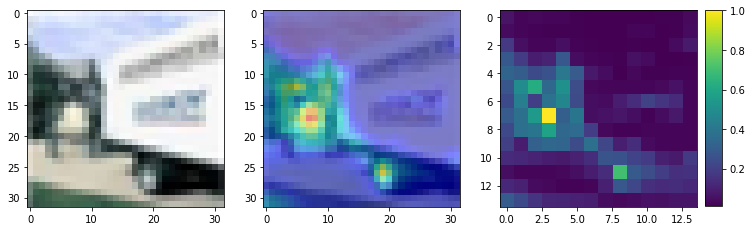

AttributeError: 'NoneType' object has no attribute 'shape'

In [31]:
# visualize out-of-distribution class attention maps.  
ood_class_name = 'truck'
ood_class_idx, img_idx = dataset.class_to_idx[ood_class_name], 888
original_img = dataset.img_dict[ood_class_idx][img_idx]

test_img = dataset.get_transformed_image(ood_class_idx, img_idx)
test_img = test_img.to(device=device)
attention_maps = compute_attention_maps(config, model, test_img.unsqueeze(0))
logits = compute_logits(config, model, test_img.unsqueeze(0))
max_logit, max_class = logits.max(1)
print('max logit:', max_logit.item())
print('max class:', idx_to_class[max_class.item()])
print('logit:', logits.detach().cpu().numpy())
print('attn weights:', len(attention_maps), attention_maps[0].shape)

mask = visualize_results(original_img, attention_maps, 333)
print(mask.shape)